# Enfrentando o Dragão
**Mural de Quests 04 - Jardim do Palácio**

**Disciplina:** Aprendizado de Máquina

**Professor:** Daniel R. Cassar

**Alunas:** Lília Gavazza, Lívia Aragão, Sophia Alves

### Minha saúde não é de ferro não, mas meus nervos são de aço (ou de cobalto?)!
Esse material corresponde ao projeto de disciplina de Aprendizado de Máquina, correspondendo à condensação de todos os conhecimentos adquiridos durante o semestre, além de adicionais que indicam que nós somos leitoras atentas e procuramos sempre destrinchar os aprendizados parte por parte. Aqui se desenvolveu um projeto para prever magnetização de compostos de cobalto (Co) a partir de modelagem de cinco algoritmos de aprendizado de máquina, aprimorados com otimização de hiperparâmetros e ferramentas de explicações de modelos. Condense todo esse conhecimento e sinta a atração magnética desse trabalho!

In [2]:
# Importando bibliotecas e funções necessárias
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import shap
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from optuna import create_study

# [Modelos]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

ModuleNotFoundError: No module named 'shap'

O cobalto é um metal fortemente magnético. Seus elétrons desemparelhados no orbital 3d conseguem atuam como pequenos ímas que conseguem se alinahar a um campo magnético que estejam submetidos, gerando um momento magnético resultante. Mesmo cessando o fluxo do campo, essa orenação dos spins e a consequente magnetização permanecem, sendo caracterizado como um metal de ordenção magnética ferromagnética. Além disso, a estrutura cristalina também é um fator que influencia o tipo de magnetização de um material, devido dependências direcionais das propriedades magnéticas. O cobalto possui uma estrutura cristalina hexagonal que contribui bastante para sua anisotropia magnética, aumentando a estabilidade e confiabilidade em aplicações magnéticas desse metal. No entanto, ao analisar compostos cristalinos binários derivados do cobalto, nem sempre eles possuem magnetização ferromagnética. Dependo do outro elemento, a estrutura, a estabilidade, as propriedades eletrônicas, o volume, a densidade, entre outros parâmetros são alterados, podendo causar tipos de ordenações magnéticas distintas.

O Materials Project é uma base de dados aberta que fornece informações sobre materiais já conhecidos ou preditos por supercomputação alinhada a métodos já consagrados para ajudar na projeção de novos materiais. Nele, pode-se filtrar os mais de 200000 registrados de acordo com o interesse do usuário. Sob a ótica da análise anterior, foram selecionados os materiais binários que contivessem cobalto e fossem experimentalmente observáveis, para realmente trabalhar com compostos da realidade.

Neles, existem quatro tipos de ordem de magnetização possíveis para um material:

- FM - Ferromagnéticos
- FiM - Ferrimagnéticos
- AM - Antimagnéticos
- NM - Não magnéticos

Pode-se então, retirando as colunas que apenas identificam os materiais, realizar modelos de aprendizado de máquina que tentam prever qual tipo de ordenação magnética de um material baseado em outras informações fornecidas por essa base de dados, avaliando a influência de diversos fatores na propiedadesob análise. Vale ressaltar que a magnetização total não será considerada para que o modelo realmente parta "às cegas" quanto as propriedades magnéticas!

Portanto, esse notebook busca prever o magnetismo de compostos binários de cobalto a partir de suas propriedades estruturais e estruturas eletrônicas. Para tal, realiza a otimização por optuna de seis modelos distintos: k-vizinhos, árvore de classificação, floresta aleatória, NaiveBayes Gaussiano, SVC ("Support Vector Classifier") e regressão logística, medindo-se a acurácia de cada um deles. Em seguida, são feitos os treinos dos melhore modelos obtidos e são comparadas as acurácias obtidas. Por fim, avaliou-se a importância de cada atributo para a previsão final de cada modelo por meio do SHAP.

### 1. Dataset - Compostos binários de cobalto
Foram selecionados, utilizando ferramentas do próprio site do Materials Project, apenas os compostos binários que tivessem cobalto. Deles foram selecionadas as seguintes propriedades:
- **Estrutura Cristalina:** indica o arranjo espacial dos átomos nas redes cristalinas;
- **Número de sítos:** número de posições atômicas na célula unitária, ou seja, quantos átomos em cada uma delas;
- **Energia acima de Hull:** medida de estabilidade termodinâmica, quanto menor, mais estável é o composto;
- **Energia de formação:** energia liberada/formada ao sintetizar o composto a partir de substâncias simples;
- **Volume:** volume da célula unitária;
- **Densidade:** razão de massa por volume total ($g cm^{-3}$), dependendo dos átomos presentes e da estrutura cristalina;
- **_Band Gap_:** diferença entre a energia da banda de valência e da banda de condução;
- **É _gap direct_?:** se os elétrons podem transitar entre as bandas sem requerer excitação;
- **É metal?:** se sim, o _band gap_ é igual ou muito próximo de zero.

Dessa maneira, são descritas propriedades estruturais e eletrônicas mais gerais de cada material. Tais fatores influenciam a ordenação magnética. A ordenação e o empacotamento influenciam o acoplamento magnético []; sítios distintos e em diferntes configurações podem gerar competições e frutrações de comportamentos magnéticos; com muita estabilidade, tende a não ocorrer o alinhamento dos spins, gerando mais materiais antimagnéticos ou não magnéticos; por fim, o _band gap_ e suas consequências é um dos fatores mais decisivos, determinando um magnetismo fixo ou intinerante que influencia na capacidade de alinhamento dos elétrons.

Vejamos, então, os 269 compostos que se enciaxam nas condições mencionadas.

In [3]:
nome_do_arquivo = "magnetismo_Co(in).csv"
magnetic_co = pd.read_csv(nome_do_arquivo)
magnetic_co

,Material ID,Formula,Crystal System,Sites,Energy Above Hull,Formation Energy,Volume,Density,Band Gap,Is Gap Direct,Is Metal,Magnetic Ordering,Total Magnetization
0,mp-1079523,CoO4,Monoclinic,10,0.599108,-0.044351,196.489565,2.077783,0.0161,False,False,FM,1.999108e+00
1,mp-1079143,CoGe,Monoclinic,8,0.665773,0.593298,129.051169,6.771963,0.0000,False,True,FM,4.376266e+00
2,mp-21237,CoGe,Monoclinic,8,0.000000,-0.072475,103.639401,8.432408,0.0000,False,True,NM,1.000000e-07
3,mp-30568,Zn13Co,Monoclinic,14,0.000000,-0.040924,194.369648,7.767908,0.0000,False,True,NM,0.000000e+00
4,mp-556750,CoO2,Monoclinic,3,0.163029,-0.909404,78.480112,1.924005,0.0000,False,True,FM,1.000021e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,mp-542327,Ce5Co19,Trigonal,24,0.018929,-0.127443,338.651428,8.925688,0.0000,False,True,FiM,1.751113e+01
265,mp-1197433,Sm5Co19,Hexagonal,48,0.033788,-0.029233,688.194785,9.031600,0.0000,False,True,FiM,2.681838e+01
266,mp-1192795,Hf6Co23,Cubic,29,0.000000,-0.219459,369.940215,10.891321,0.0000,False,True,FiM,3.261672e+01
267,mp-30569,Zr6Co23,Cubic,29,0.000000,-0.201585,377.992464,8.359125,0.0000,False,True,FiM,3.258866e+01


### 2. Carregando os dados

Vamos usar o pandas para fazer a leitura e tratar os dados do dataset utilizado.

In [ ]:
colunas = ["Crystal System", "Sites", "Energy Above Hull", 
           "Formation Energy", "Volume", "Density", "Band Gap", "Is Gap Direct", "Is Metal",
           "Magnetic Ordering"] #estabelecendo as colunas 

nome_do_arquivo = "magnetismo_Co(in).csv"
magnetic_co = pd.read_csv(nome_do_arquivo) #leitura do arquivo csv

magnetic_co = magnetic_co.dropna() # retirar linhas com valores vazios 
magnetic_co = magnetic_co.reindex(colunas, axis = 1) #seleciona as colunas especificadas

Observando o dataframe dos nossos dados, vemos que existem algumas colunas categóricas e que o próprio alvo (target) é categórico. Para realizar a conversão simbólico-numérica, iremos usar as técnicas de conversão simbólico-numérica de LabelEncoder e OneHotEncoder. Essa conversão possibilita que o modelo consiga entender melhor os dados e, portanto, aprender com eles.

Ambas as técnicas transformam dados categóricos em dados númericos, onde o LabelEncoder atribui um número a cada dado categórico que passa pela transformação e o OneHotEncoder atribui valores de 0 quando indica ausência e 1 quando indica presença da categoria. 

In [ ]:
label_encoder = LabelEncoder() #instanciando o conversor 
magnetic_co["Magnetic Ordering"] = label_encoder.fit_transform(magnetic_co["Magnetic Ordering"]) #fitando a transformação

print("Mapeamento do Label Encoder:")
for i, classe in enumerate(label_encoder.classes_):
    print(f"  {classe} -> {i}")   #imprime cada atribuição do LabelEncoder às variáveis categóricas
    ])

NameError: name 'LabelEncoder' is not defined

### 3. Etapa da divisão de dados de treino e de teste

Para que possamos criar bons modelos, precisamos dividir os dados, isto é: separar parte deles com a finalidade de treinar o modelo e a outra parte, para testar a performance do modelo. Usamos a função `train_test_split` do scikit-learn, definindo os parâmetros de tamanho do teste e o random_state (responsável pela garantia da reprodutibilidade dos dados).

In [ ]:
indices = magnetic_co.index
indices_treino, indices_teste = train_test_split(
    indices, test_size = TAMANHO_TESTE, random_state = SEMENTE_ALEATORIA)

# Definição dos DataFrames com os dados de treino e de teste
treino_mco = magnetic_co.loc[indices_treino]
teste_mco = magnetic_co.loc[indices_teste]

FEATURES = ["Crystal System", "Sites", "Energy Above Hull", "Is Metal", "Is Gap Direct",
           "Formation Energy", "Volume", "Density", "Band Gap"]
TARGET = ["Magnetic Ordering"]


# Separação e seleção dos valores de features e target por DF
X_treino = treino_mco.reindex(FEATURES, axis = 1)
y_treino = treino_mco.reindex(TARGET, axis = 1).values.ravel()

X_teste = teste_mco.reindex(FEATURES, axis = 1)
y_teste = teste_mco.reindex(TARGET, axis = 1).values.ravel()

Mapeamento do Label Encoder:
  AFM -> 0
  FM -> 1
  FiM -> 2
  NM -> 3


categorical_cols = X_treino.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
numerical_cols = X_treino.select_dtypes(include=[np.number]).columns.tolist()

preprocessador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)

In [5]:
preprocessador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

#### Baseline 
Esse é o modelo base, o qual ele se baseia e prevê a classe mais frequente para todos os dados. Não existe necessidade, portanto, de avaliar o melhor conjunto de hiperparâmetro, pois eles não existem nesse caso. O baseline é muito importante para termos consciência da qualidade do nosso modelo, já que, se o programa aponta, com base em métricas de erro, que o baseline é melhor que o modelo proposto, então muito tem que se melhorar nesse modelo, já que o baseline, prevendo a classe mais recorrente, possui melhor rendimento que o modelo elaborado. 

Aqui é definida uma pipeline: um objeto que irá encadear diversos passos de pré-processamento e de modelagem, tornando o processo mais organizado e evitando vazamento de dados. O argumento "strategy" informa como o baseline irá atuar e prever os dados. No caso, o baseline irá atuar pelo método "stratified", seguindo a distribuições de cada classe dos dados.

In [6]:
pipeline_bsl = Pipeline([
    ("prep", preprocessador),
    ("dummy", DummyClassifier(strategy='stratified', random_state=SEMENTE_ALEATORIA))
])
    
pipeline_bsl.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto1 = pipeline_bsl.predict(X_teste)

acuracia_bsl = accuracy_score(y_verdadeiro, y_previsto1)
print(f"Acurácia - Baseline: {round((acuracia_bsl)*100, 2)}%")

Acurácia - Baseline: 40.74%


Esse desempenho será o nosso norte quanto a real capacidade de generalização dos próximos algoritmos, pensando que quanto maior e mais distante dessa base, melhor é o modelo induzido.

### Otimização de Hiperparâmetros com `optuna`
O `optuna` é um módulo de python que permite uma otimização de hiperparâmetros por uma espécie de "conjunto de tentativas". O `trial` é um objeto dele que sorteia e sugere parâmetros para o modelo, criando seu espaço de busca de hiperparâmetros. 

Disso, é definida a função objetivo para medir, reforçada por uma validação cruzada k-fold, a métrica sob análise, nesse caso, a acurácia. Efetivamente o que ocorre é que o conjunto de hiperparâmetros sugerido no passo anterior é avaliado por essa estratégia, que devolve a estimativa de desempenho dele para guiar e comparar com as próximas escolhas. Isso é feito por uma subdivisão dos dados de treino em $k$ subconjuntos, que serão utilizados como dados de teste uma vez. A média das $k$ estimativas de desempenho obtidas é mais robusta em determinar a performance do modelo "induzido".

Por fim, a criação do objeto de estudo define o otimizador desse problema de maximização que será rodado com módulo `optimize` um determinado número de tentativas (100). Os melhores parâmetros encontrados serão os utilizados para realmente induzir o modelo e calcular sua acurácia

#### k-NN Classificador
Esse modelo se baseia na moda de classes de n dos seus vizinhos para prever um dado desconhecido. Seus principais hiperparâmetros são:
- `n_neighbors`: o número de vizinhos a serem considerados na análise da moda;
- `weights`: como as classes dos vizinhos influenciam na previsão, de forma uniforme com todos tendo o meso peso ou de forma guiada pela distância, os mais próximos tem maior peso;
- `p`: o tipo de distância considerada na determinação dos vizinhos mais próximos.

Também será analisada a influência/necessidade da normalização dos dados.

In [34]:
def instancia_kNN(trial):
    parametros_kNN = {
        "n_neighbors": trial.suggest_int("num_vizinhos", 1, 100, log=True),
        "weights": trial.suggest_categorical("pesos", ["uniform", "distance"]),
        "p": trial.suggest_float("potencia_minkowski", 1, 2),
        "n_jobs": -1 # processamento
    }
    
    modelo_kNN = Pipeline([
            ("pre", preprocessador),
            ("kNN", KNeighborsClassifier(**parametros_kNN))
    ])

    return modelo_kNN           

def func_obj_kNN(trial, X, y, n_folds):
    
    modelo = instancia_kNN(trial)

    metricas_kNN = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        cv=n_folds,
        error_score='raise'
    )

    return metricas_kNN.mean()

NOME_DO_ESTUDO = "kNN"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 01:04:00,942] A new study created in RDB with name: kNN


In [35]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_kNN(trial):
    return func_obj_kNN(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_kNN, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 01:04:03,883] Trial 0 finished with value: 0.5619047619047619 and parameters: {'num_vizinhos': 49, 'pesos': 'distance', 'potencia_minkowski': 1.7857183459835033}. Best is trial 0 with value: 0.5619047619047619.
[I 2025-11-04 01:04:04,167] Trial 1 finished with value: 0.4960034013605442 and parameters: {'num_vizinhos': 54, 'pesos': 'uniform', 'potencia_minkowski': 1.0488729247902493}. Best is trial 0 with value: 0.5619047619047619.
[I 2025-11-04 01:04:04,517] Trial 2 finished with value: 0.5620748299319728 and parameters: {'num_vizinhos': 1, 'pesos': 'distance', 'potencia_minkowski': 1.782429240491588}. Best is trial 2 with value: 0.5620748299319728.
[I 2025-11-04 01:04:04,872] Trial 3 finished with value: 0.5704081632653061 and parameters: {'num_vizinhos': 2, 'pesos': 'distance', 'potencia_minkowski': 1.6372603429494774}. Best is trial 3 with value: 0.5704081632653061.
[I 2025-11-04 01:04:05,238] Trial 4 finished with value: 0.5704931972789116 and parameters: {'num_vizinh

In [53]:
melhor_trial_kNN = objeto_de_estudo.best_trial

modelo_kNN = instancia_kNN(melhor_trial_kNN)
modelo_kNN.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto2 = modelo_kNN.predict(X_teste)

f1_kNN = f1_score(y_verdadeiro, y_previsto2, average = "weighted")

print(f"Melhor trial: {melhor_trial_kNN.number} - Parâmetros: {melhor_trial_kNN.params}")
print(f"Acurácia - kNN: {f1_kNN}")



Melhor trial: 63 - Parâmetros: {'num_vizinhos': 22, 'pesos': 'distance', 'potencia_minkowski': 1.4059139009808481}
Acurácia - kNN: 0.7977207977207977


PermutationExplainer explainer: 28it [00:19,  1.42s/it]                        
C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\1198686353.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


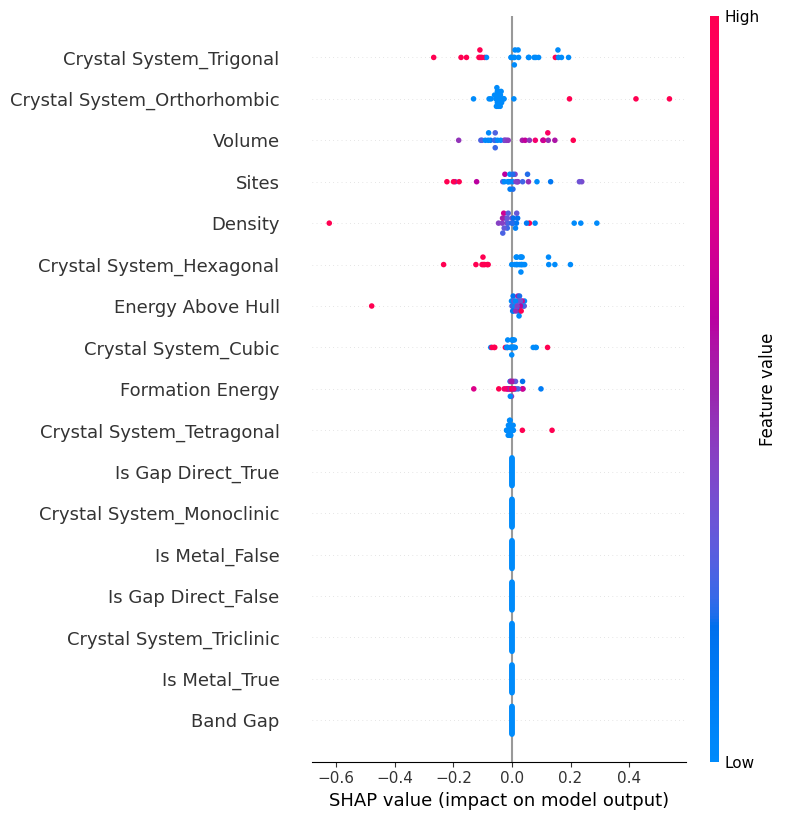

In [52]:
# 1. Acessar o OHE dentro do ColumnTransformer
ohe = modelo_kNN.named_steps['pre'].named_transformers_['cat']
 
# 2. Recuperar nomes das colunas expandidas
categorical_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, categorical_feature_names])
 
# 3. Transformar dados de teste (usando o mesmo preprocessador)
X_teste_transformado = modelo_kNN.named_steps['pre'].transform(X_teste)
 
# 4. Extrair modelo final (KNN)
modelo_final = modelo_kNN.named_steps['kNN']
 
# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")
 
# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)
 
# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)



#### Árvore de Decisão
As previsões são feitas por meio da sudivisão dos dados de acordo com limiares de um determinado critério. Seus principais hiperparâmetros são:
- `max_leaf_nodes`: número máximo de vértices folha;
- `max_depth`: máxima profundidade da árvore de decisão gerada;
- `min_samples_split`: número mínimo de exemplos para gerar uma divisão condicional deles;
- `min_samples_leaf`: número mínimo de exemplos em um vértice folha.

Novamente, a possibilidade de normalização foi considerada.

In [10]:
def instancia_ad(trial):
    parametros_ad = {
        "max_leaf_nodes": trial.suggest_int("num_maximo_nos", 2, 20),
        "max_depth": trial.suggest_categorical("profundidade_maxima", [None, 3, 6, 9, 12, 18, 21, 24]),
        "min_samples_split": trial.suggest_int("min_exemplos_vcondicional", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_exemplos_vfolha", 1, 20),
        "random_state": 73 #reprotibilidade
    }

    modelo_ad = Pipeline([
            ("pre", preprocessador),
            ("arv_dec", DecisionTreeClassifier(**parametros_ad))
    ])

    return modelo_ad

def func_obj_ad(trial, X, y, n_folds):
    modelo = instancia_ad(trial)

    metricas_ad = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        
        cv=n_folds
    )

    return metricas_ad.mean()

NOME_DO_ESTUDO = "arvore_de_decisao"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 00:19:30,738] Using an existing study with name 'arvore_de_decisao' instead of creating a new one.


In [11]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_ad(trial):
    return func_obj_ad(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_ad, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 00:19:31,195] Trial 100 finished with value: 0.5409863945578232 and parameters: {'num_maximo_nos': 8, 'profundidade_maxima': 18, 'min_exemplos_vcondicional': 8, 'min_exemplos_vfolha': 5}. Best is trial 52 with value: 0.5698979591836735.
[I 2025-11-04 00:19:31,528] Trial 101 finished with value: 0.5284863945578231 and parameters: {'num_maximo_nos': 9, 'profundidade_maxima': 21, 'min_exemplos_vcondicional': 4, 'min_exemplos_vfolha': 3}. Best is trial 52 with value: 0.5698979591836735.
[I 2025-11-04 00:19:31,970] Trial 102 finished with value: 0.5119897959183672 and parameters: {'num_maximo_nos': 10, 'profundidade_maxima': 6, 'min_exemplos_vcondicional': 5, 'min_exemplos_vfolha': 2}. Best is trial 52 with value: 0.5698979591836735.
[I 2025-11-04 00:19:32,412] Trial 103 finished with value: 0.4837585034013606 and parameters: {'num_maximo_nos': 8, 'profundidade_maxima': 21, 'min_exemplos_vcondicional': 6, 'min_exemplos_vfolha': 19}. Best is trial 52 with value: 0.5698979591836

In [12]:
melhor_trial_ad = objeto_de_estudo.best_trial

modelo_ad = instancia_ad(melhor_trial_ad)
modelo_ad.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto3 = modelo_ad.predict(X_teste)

acuracia_ad = accuracy_score(y_verdadeiro, y_previsto3)

print(f"Melhor trial: {melhor_trial_ad.number} - Parâmetros: {melhor_trial_ad.params}")
print(f"Acurácia - Árvore de Decisão: {acuracia_ad}")

Melhor trial: 197 - Parâmetros: {'num_maximo_nos': 20, 'profundidade_maxima': 3, 'min_exemplos_vcondicional': 6, 'min_exemplos_vfolha': 5}
Acurácia - Árvore de Decisão: 0.7037037037037037


C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\1924140299.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


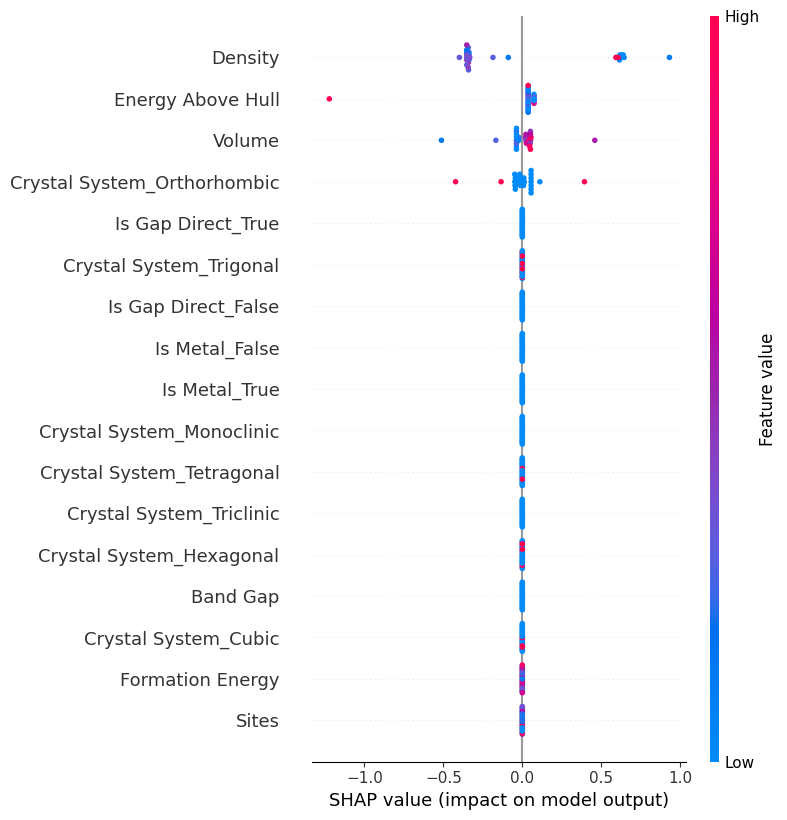

In [55]:
# 4. Extrair modelo final (Árvore de Decisão)
modelo_final = modelo_ad.named_steps['arv_dec']

# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")

# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)

# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


#### Floresta Aleatória
Nesse algoritmos são projetadas vários conjuntos de árvores de decisão, tentando criar um modelo de maior variância e menor viés. Seus principais hiperparâmetros são:
- `n_estimators`: número de árvores por comitê;
- `min_samples_split`: número mínimo de exemplos para gerar uma divisão condicional deles;
- `min_samples_leaf`: número mínimo de exemplos em um vértice folha;
- `max_features`: fração de atributos usada em cada _split_ das árvores;
- `bootstrap`: se ocorre uma amostragem do tipo _bootstrap_ dos exemplos para treinar as árvores.

In [13]:
def instancia_fa(trial):
    parametros_fa = {
        "n_estimators": trial.suggest_int("num_arvores", 50, 500, log=True),
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 10),
        "max_features": trial.suggest_float("num_max_atributos", 0, 1),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1, #processamento
        "random_state": 73 #reprodutibilidade
    }

    modelo_fa = Pipeline([
            ("pre", preprocessador),
            ("flo_ale", RandomForestClassifier(**parametros_fa))
    ])      
    

    return modelo_fa

def func_obj_fa(trial, X, y, num_folds):
    modelo = instancia_fa(trial)

    metricas_fa = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        cv=num_folds,
    )

    return metricas_fa.mean()

NOME_DO_ESTUDO = "floresta_aleatoria"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 00:20:17,338] A new study created in RDB with name: floresta_aleatoria


In [14]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_fa(trial):
    return func_obj_fa(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_fa, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 00:20:21,359] Trial 0 finished with value: 0.5909013605442176 and parameters: {'num_arvores': 149, 'min_exemplos_split': 5, 'min_exemplos_folha': 1, 'num_max_atributos': 0.041194294113844565, 'bootstrap': True}. Best is trial 0 with value: 0.5909013605442176.
[I 2025-11-04 00:20:26,167] Trial 1 finished with value: 0.590561224489796 and parameters: {'num_arvores': 316, 'min_exemplos_split': 6, 'min_exemplos_folha': 3, 'num_max_atributos': 0.570563946734673, 'bootstrap': False}. Best is trial 0 with value: 0.5909013605442176.
[I 2025-11-04 00:20:31,607] Trial 2 finished with value: 0.5659863945578232 and parameters: {'num_arvores': 475, 'min_exemplos_split': 8, 'min_exemplos_folha': 9, 'num_max_atributos': 0.4041102385097236, 'bootstrap': False}. Best is trial 0 with value: 0.5909013605442176.
[I 2025-11-04 00:20:34,401] Trial 3 finished with value: 0.574234693877551 and parameters: {'num_arvores': 162, 'min_exemplos_split': 9, 'min_exemplos_folha': 4, 'num_max_atributos':

In [15]:
melhor_trial_fa = objeto_de_estudo.best_trial

modelo_fa = instancia_fa(melhor_trial_fa)
modelo_fa.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto4 = modelo_fa.predict(X_teste)

acuracia_fa = accuracy_score(y_verdadeiro, y_previsto4)

print(f"Melhor trial: {melhor_trial_fa.number} - Parâmetros: {melhor_trial_fa.params}")
print(f"Acurácia - Floresta Aleatória: {acuracia_fa:.2f}")

Melhor trial: 52 - Parâmetros: {'num_arvores': 162, 'min_exemplos_split': 3, 'min_exemplos_folha': 1, 'num_max_atributos': 0.13133138561395297, 'bootstrap': True}
Acurácia - Floresta Aleatória: 0.81


PermutationExplainer explainer: 28it [00:39,  1.88s/it]                        
C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\3028778944.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


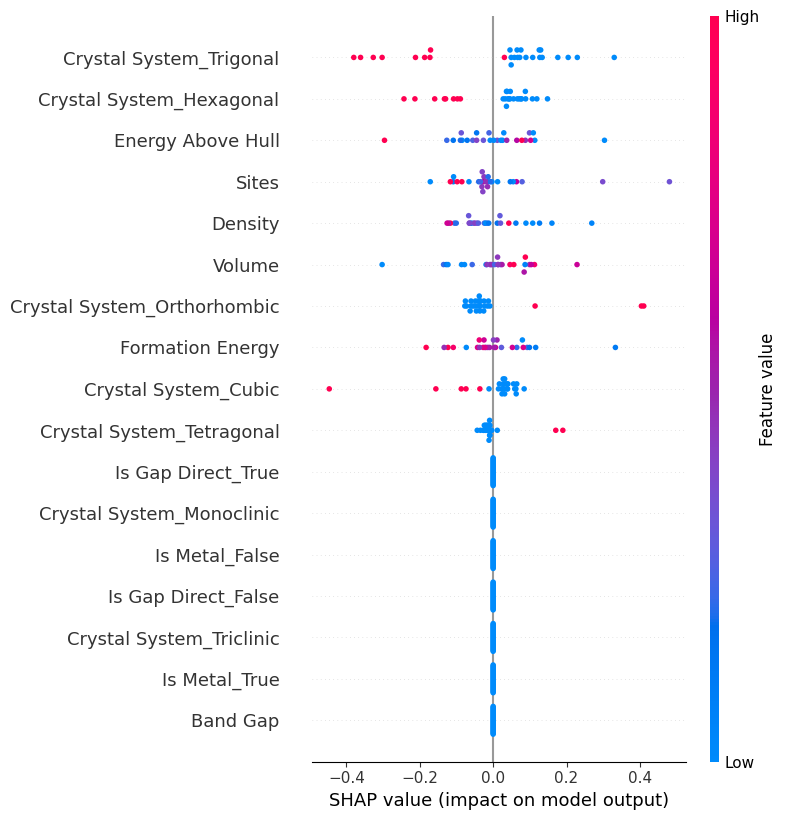

In [56]:
# 4. Extrair modelo final (Floresta Aleatória)
modelo_final = modelo_fa.named_steps['flo_ale']

# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")

# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)

# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)

#### Naive Bayes Gaussiano
Esse algoritmo assume _features_ independentes e faz previsões baseadas nas probailidades das classes assumindo as _features_ em distribuição gaussiana e o Teorema de Bayes. Seu principal hiperparâmetro é:
- `var_smoothing`: controla a variância que afeta as distribuições das _features_, para aumentar a estabilidade da previsão.

In [16]:
def instancia_nbg(trial):
    parametros_nbg = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-11, 1e-1, log=True)
    }

    modelo_nbg = Pipeline([
        ("pre", preprocessador),
        ("nbg", GaussianNB(**parametros_nbg))
    ])
    
    return modelo_nbg

def func_obj_nbg(trial, X, y, num_folds):
    modelo = instancia_nbg(trial)

    metricas_nbg = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        cv=num_folds,
    )

    return metricas_nbg.mean()

NOME_DO_ESTUDO = "naive_bayes_gaussiano"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 00:25:47,650] A new study created in RDB with name: naive_bayes_gaussiano


In [17]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_nbg(trial):
    return func_obj_nbg(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_nbg, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 00:25:47,954] Trial 0 finished with value: 0.4337585034013605 and parameters: {'var_smoothing': 3.2851082033926236e-05}. Best is trial 0 with value: 0.4337585034013605.
[I 2025-11-04 00:25:48,162] Trial 1 finished with value: 0.4254251700680272 and parameters: {'var_smoothing': 1.8726754298083208e-06}. Best is trial 0 with value: 0.4337585034013605.
[I 2025-11-04 00:25:48,361] Trial 2 finished with value: 0.4337585034013605 and parameters: {'var_smoothing': 3.638889267890638e-05}. Best is trial 0 with value: 0.4337585034013605.
[I 2025-11-04 00:25:48,585] Trial 3 finished with value: 0.42551020408163265 and parameters: {'var_smoothing': 2.601906893873876e-10}. Best is trial 0 with value: 0.4337585034013605.
[I 2025-11-04 00:25:48,820] Trial 4 finished with value: 0.5744047619047619 and parameters: {'var_smoothing': 0.06246530007107555}. Best is trial 4 with value: 0.5744047619047619.
[I 2025-11-04 00:25:49,058] Trial 5 finished with value: 0.4545918367346939 and parameter

In [18]:
melhor_trial_nbg = objeto_de_estudo.best_trial

modelo_nbg = instancia_nbg(melhor_trial_nbg)
modelo_nbg.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto5 = modelo_nbg.predict(X_teste)

acuracia_nbg = accuracy_score(y_verdadeiro, y_previsto5)

print(f"Melhor trial: {melhor_trial_nbg.number} - Parâmetros: {melhor_trial_nbg.params}")
print(f"Acurácia - Naive Bayes Gaussiano: {acuracia_nbg:.2f}")

Melhor trial: 73 - Parâmetros: {'var_smoothing': 0.057238310396854016}
Acurácia - Naive Bayes Gaussiano: 0.74


C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\4241132805.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


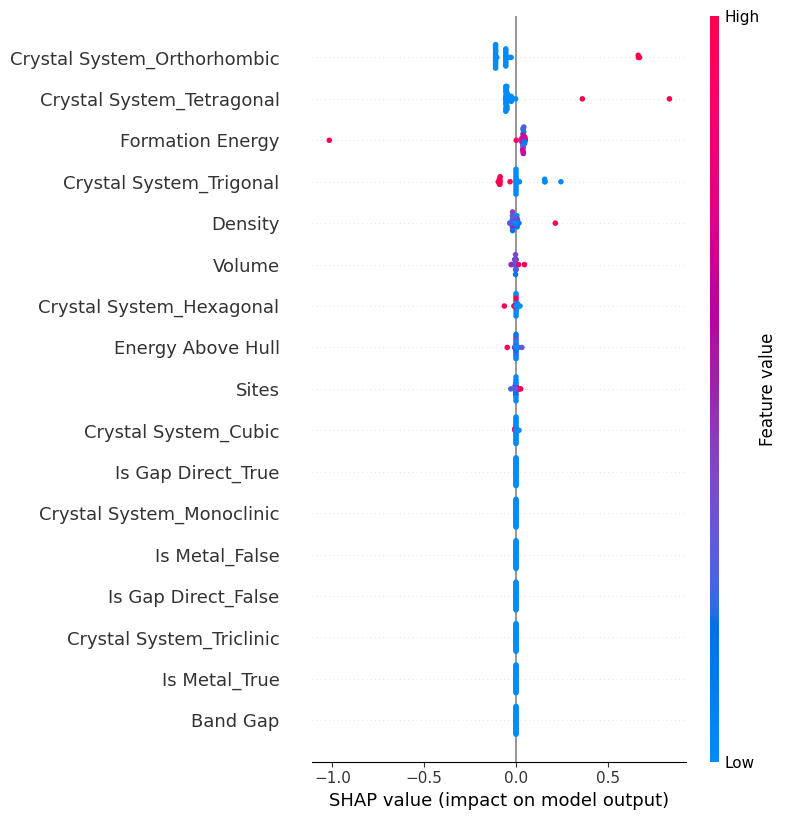

In [58]:
# 4. Extrair modelo final (Naive Gaussian Bayes)
modelo_final = modelo_nbg.named_steps['nbg']

# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")

# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)

# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)

#### Support Vector Classification - SVC
Nesse modelo, a multiclassficação é subdividida em problemas de classificação binária. Em cada um deles, procura o hiperplano que melhora separa as diferentes classes. Seus principais hiperparâmetros são:
- `kernel`: método de separação dos grupos;
- `C`: parâmetro de regularização;
- `gamma`: controla a influência de cada ponto de treino em _kernels_ não lineares;

`max_iter`é um parâmetro desse modelo que limita o número de iterações feitas pelo modelo prar tentar convergir, sendo definido para uma relativa simplificação do modelo.

In [19]:
def instancia_svc(trial):
    parametros_svc = {
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"]),
        "C": trial.suggest_float("C", 0.01, 100, log=True),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "max_iter": 5000,
        "random_state": 73 #reprodutibilidade
    }

    modelo_svc = Pipeline([
        ("pre", preprocessador),
        ("svc", SVC(**parametros_svc))
    ])

    return modelo_svc  



def func_obj_svc(trial, X, y, num_folds):
    modelo = instancia_svc(trial)

    metricas_svc = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        cv=num_folds,
    )

    return metricas_svc.mean()

NOME_DO_ESTUDO = "svc"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 00:26:12,276] A new study created in RDB with name: svc


In [20]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_svc(trial):
    return func_obj_svc(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_svc, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 00:26:12,604] Trial 0 finished with value: 0.5827380952380952 and parameters: {'kernel': 'poly', 'C': 7.557549104082885, 'gamma': 'scale'}. Best is trial 0 with value: 0.5827380952380952.
[I 2025-11-04 00:26:12,908] Trial 1 finished with value: 0.5121598639455783 and parameters: {'kernel': 'sigmoid', 'C': 5.851662013738677, 'gamma': 'auto'}. Best is trial 0 with value: 0.5827380952380952.
[I 2025-11-04 00:26:13,232] Trial 2 finished with value: 0.6156462585034014 and parameters: {'kernel': 'rbf', 'C': 1.8641746290972205, 'gamma': 'auto'}. Best is trial 2 with value: 0.6156462585034014.
[I 2025-11-04 00:26:13,531] Trial 3 finished with value: 0.37193877551020404 and parameters: {'kernel': 'poly', 'C': 0.022257752200824096, 'gamma': 'auto'}. Best is trial 2 with value: 0.6156462585034014.
[I 2025-11-04 00:26:13,848] Trial 4 finished with value: 0.5454081632653061 and parameters: {'kernel': 'poly', 'C': 88.00571562942521, 'gamma': 'scale'}. Best is trial 2 with value: 0.6156

In [21]:
melhor_trial_svc = objeto_de_estudo.best_trial

modelo_svc = instancia_svc(melhor_trial_svc)
modelo_svc.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto7 = modelo_svc.predict(X_teste)

acuracia_svc = accuracy_score(y_verdadeiro, y_previsto7)

print(f"Melhor trial: {melhor_trial_svc.number} - Parâmetros: {melhor_trial_svc.params}")
print(f"Acurácia - SVC: {acuracia_svc}")

Melhor trial: 74 - Parâmetros: {'kernel': 'rbf', 'C': 2.4179631024245922, 'gamma': 'auto'}
Acurácia - SVC: 0.8148148148148148


C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\878326848.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


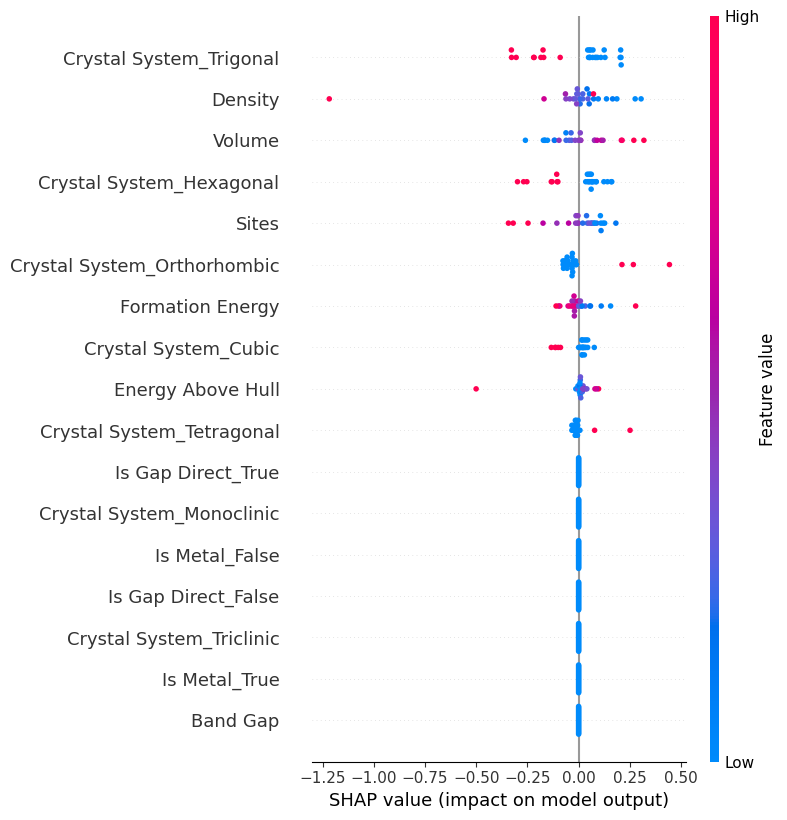

In [64]:
# 4. Extrair modelo final (Naive Gaussian Bayes)
modelo_final = modelo_svc.named_steps['svc']

# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")

# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)

# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)

#### Regressão Logística
Por fim, no modelo de regressão logística encontramos uma procura pelo maior ajuste possível entre uma variável do tipo atributo e uma variável destino para prever a probabilidade de uma variável ter um rótulo 1 dado um certo grupo de atributos. Os argumentos (hiperparâmetros) da função de modelo de regressão logística são:

- penalty: especifica o tipo de regularização aplicada
- solver: algoritmo utilizado para encontrar os melhores coeficientes para o modelo
- C: parâmetro relativo ao inverso da força de regularização
- max_iter: número máximo de iterações que o solver tentará executar para que o modelo tenha uma solução ótima
- tol: tolerância, é o critério de parada para o solver.
- l1_ratio: define a proporção da penalidade L1 na combinação Elastic Net

Nesse caso, ao trabalhar com a otimização de hiperparâmetros pelo optuna e o algoritmo de regressão logística, alguns detalhes devem ser observados. Abaixo, as funções características do optuna foram elaboradas, com a inserção de dois comandos: OvR (One-vs-Rest), que lida com problemas de classificação multiclasse. É uma estratégia de relacionar multiclasses com a ideia de binário, um e o resto. Nas funções abaixo, a estrate´gia de OvR foi necessária para melhorar a performance do optuna e evitar ocorrência de erros, além de procurar qual melhor grupo "binário" tem a maior pontuação de confiança.

Já outro comando que deve ser comentado é o de TrialPruned, pertencente à biblioteca optuna usada anteriormente para otimização de hiperparâmetros. Ele implementa a técnica de "pruning": parar antecipadamente os "trials" (testes) que estão performando mal, economizando tempo e recursos computacionais. Essa função foi aplicada devido ao fato de os argumentos da regressão logística não poderem ser escolhidos de forma totalmente aleatória, já que os parâmetros solver e penalty só podem ter combinações específicas, então, ao implementar essa função TrialPruned do optuna, garantimos que apenas combinações específicas podem compor o corpo do algoritmo. 

In [ ]:
def instancia_lr(trial):
    parametros_lr = {
        'penalty':  trial.suggest_categorical("penalty", ['l1','l2']),
        'C': trial.suggest_float("C", 1e-4, 1e4, log=True),
        'solver': "saga",
        'max_iter': trial.suggest_int("max_iter", 100, 5000, log=True),
        'tol': 1e-2,
        'random_state': 73
}

    modelo_lr = Pipeline([
        ("pre", preprocessador),
        ("log_reg", LogisticRegression(**parametros_lr))
    ])


    return modelo_lr


def func_obj_lr(trial, X, y, num_folds):
    modelo = instancia_lr(trial)

    metricas_svc = cross_val_score(
        modelo,
        X,
        y,
        scoring="accuracy",
        cv=num_folds,
    )

    return metricas_svc.mean()

NOME_DO_ESTUDO = "lr"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-04 00:26:44,649] A new study created in RDB with name: lr


In [23]:
NUM_FOLDS = 5
NUM_TENTATIVAS = 100

def func_obj_parcial_lr(trial):
    return func_obj_lr(trial, X_treino, y_treino, NUM_FOLDS)

objeto_de_estudo.optimize(func_obj_parcial_lr, n_trials=NUM_TENTATIVAS)

[I 2025-11-04 00:26:44,960] Trial 0 finished with value: 0.37193877551020404 and parameters: {'penalty': 'l2', 'C': 0.0005564394397399182, 'max_iter': 781}. Best is trial 0 with value: 0.37193877551020404.
[I 2025-11-04 00:26:45,259] Trial 1 finished with value: 0.5785714285714285 and parameters: {'penalty': 'l2', 'C': 375.9343389093643, 'max_iter': 607}. Best is trial 1 with value: 0.5785714285714285.
[I 2025-11-04 00:26:45,565] Trial 2 finished with value: 0.599234693877551 and parameters: {'penalty': 'l2', 'C': 0.1516536073131412, 'max_iter': 268}. Best is trial 2 with value: 0.599234693877551.
[I 2025-11-04 00:26:45,871] Trial 3 finished with value: 0.37193877551020404 and parameters: {'penalty': 'l1', 'C': 0.046288890410773595, 'max_iter': 3656}. Best is trial 2 with value: 0.599234693877551.
[I 2025-11-04 00:26:46,233] Trial 4 finished with value: 0.5704081632653061 and parameters: {'penalty': 'l1', 'C': 1.0341676078901176, 'max_iter': 222}. Best is trial 2 with value: 0.59923469

In [ ]:
melhor_trial_lr = objeto_de_estudo.best_trial

modelo_lr = instancia_lr(melhor_trial_lr)
modelo_lr.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsto7 = modelo_lr.predict(X_teste)

acuracia_lr = accuracy_score(y_verdadeiro, y_previsto7)

print(f"Melhor trial: {melhor_trial_lr.number} - Parâmetros: {melhor_trial_lr.params}")
print(f"Acurácia - Regrssão logística: {acuracia_lr}")

Melhor trial: 11 - Parâmetros: {'penalty': 'l2', 'C': 0.1726698437539959, 'max_iter': 357}
Acurácia - SVC: 0.7777777777777778


C:\Users\lilia25019\AppData\Local\Temp\ipykernel_18788\1187233094.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)


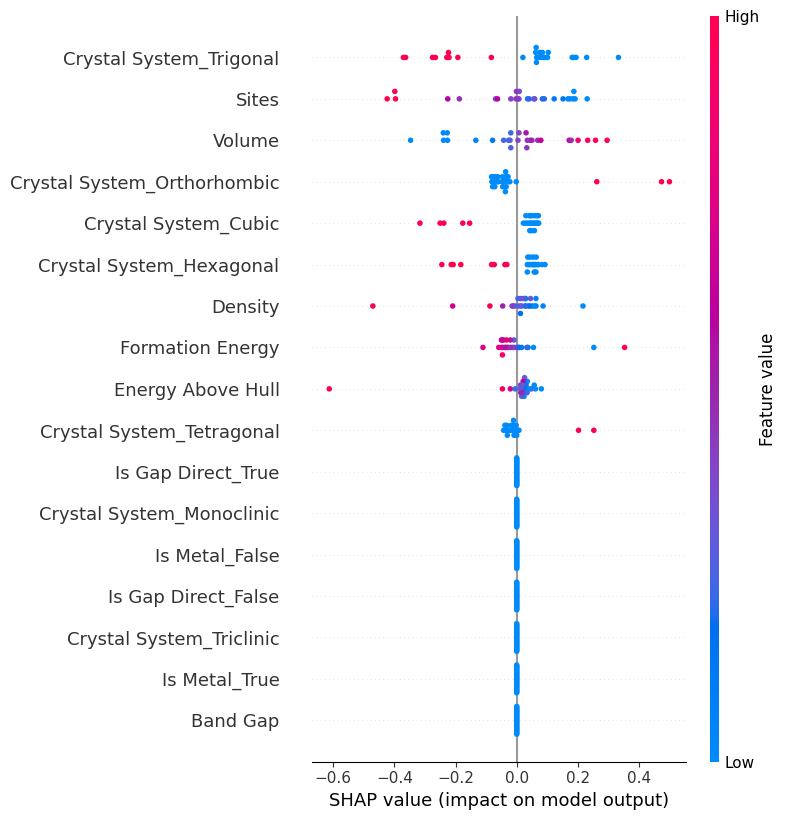

In [63]:
# 4. Extrair modelo final (Logistic Regression)
modelo_final = modelo_lr.named_steps['log_reg']

# 5. Criar o explainer SHAP
explainer = shap.Explainer(modelo_final.predict, X_teste_transformado, algorithm="permutation")

# 6. Calcular valores SHAP
shap_values = explainer(X_teste_transformado)

# 7. Visualizar resultados
shap.summary_plot(shap_values, features=X_teste_transformado, feature_names=feature_names)

### Conclusão
Abaixo se encontra uma tabela com as acurácias de cada modelo após se fazer a etapa de otimização de hiperparâmetros.

|Tipo de modelo | Acurácia |
|---|---|
| baseline|37,04%|
| kNN|64,43%|
| Árvore de decisão|55,55 %|
| Floresta Aleatória| 67,00%|
| Naives Bayes |59,00%|
| SVC |55,55%|
| Regressão Logística|62,96%|

Foi possível, portanto, escolher bons conjuntos de hiperparâmetros de cada algoritmo. Em todos eles, o melhor modelo obtido alcançou uma acurácia pelo menos próximo de 20% maior que a do _baseline_. Isso somente foi possível a partir da otimização pela combinação da busca por tentativas do `optuna` associada a escolha de melhores estimativas de métricas por validação cruzada. Essas estratégias permitem induzir modelos de melhor performance encontrando conformações que melhores lidem com dados inéditos, ou seja, generalizam e prevem as classes de novos dados.
 Veja que, nesse conjunto de dados, dentre os melhores modelos encontrados de cada algoritmo, a floresta aletória, o kNN e o SVC obtiveram no geral as maiores acurácias, sendo as melhores opções dentre as apresentadas para resolver esse problema de classificação.



### Referências
1. Is Cobalt Magnetic? Understanding Its Ferromagnetic Properties. TEAM, O. Okon Recycling. Disponível em: [https://www.okonrecycling.com/magnet-recycling-and-applications/magnet-technology/cobalt-magnetic-ferromagnetic-properties/](https://www.okonrecycling.com/magnet-recycling-and-applications/magnet-technology/cobalt-magnetic-ferromagnetic-properties/)
2. ARMYANOV, S. Crystallographic structure and magnetic properties of electrodeposited cobalt and cobalt alloys. Electrochimica Acta, v. 45, n. 20, p. 3323–3335, jun. 2000. Disponível em: [https://doi.org/10.1016/S0013-4686(00)00408-4](https://doi.org/10.1016/S0013-4686(00)00408-4)
3. Materials Project - Home. Disponível em: [https://next-gen.materialsproject.org/](https://next-gen.materialsproject.org/)
4. `sckit-learn` - Validação Cruzada. Disponível em: [https://scikit-learn.org/stable/modules/cross_validation.html](https://scikit-learn.org/stable/modules/cross_validation.html)
5. `sckit-learn` - Naive Bayes. Disponível em: [https://scikit-learn.org/stable/modules/naive_bayes.html](https://scikit-learn.org/stable/modules/naive_bayes.html)
6. BAELDUNG. Multiclass Classification Using Support Vector Machines | Baeldung on Computer Science. Disponível em: [https://www.baeldung.com/cs/svm-multiclass-classification](https://www.baeldung.com/cs/svm-multiclass-classification)
7. `sckit-learn` - `SVC`. Disponível em: [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 
8. LUNDBERG, S. Welcome to the SHAP documentation — SHAP latest documentation. Disponível em: [https://shap.readthedocs.io/en/latest/index.html](https://shap.readthedocs.io/en/latest/index.html)
9. ‌shap.Explainer — SHAP latest documentation. Disponível em: [https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html)
10. SHAP Values: Explainability of ML models in Python - Ander Fernández. Disponível em: [https://anderfernandez.com/en/blog/shap-values-python/](https://anderfernandez.com/en/blog/shap-values-python/)
‌MOLNAR, C. 5.10 SHAP (SHapley Additive exPlanations) | Interpretable Machine Learning. [s.l: s.n.].
11. CASSAR, Daniel. Materiais de Aula.